---
# 課題5 - 機械学習

本課題で使用するデータセットは[こちら](https://drive.google.com/drive/folders/1B_eW0ZXlnZC8SahPfgWB6bMQDNs-Xu-B)からダウンロードしてください。

GPUを使いたい場合は本ファイルをGoogle Colaboratoryで読み込み使用してください。

使用するデータセットの詳細リンクはそれぞれ下記の通りです。なお、どのデータセットも本課題用に一部加工しています。

[mobile-price-classification](https://www.kaggle.com/iabhishekofficial/mobile-price-classification)

[newyork-stock-exchange](https://www.kaggle.com/dgawlik/nyse)

[newyork-city-taxi-fare-prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data)

---

課題1: データセット「mobile-price-classfication」は携帯電話の端末ごとの情報と価格ランク（price_range）が記録されている。

このデータを元に、**価格ランク（price_range）**を予測するモデルを構築せよ。

【データ】

- train.csv
    - 学習用のデータ
    - 携帯電話、スマートフォン各機種のスペックと価格ランク（price_range）が記録されたデータ。価格ランクは0~3の4段階ある。
    
    
- test.csv
    - 精度検証用のデータ
    - train.csvと同じカラム構成。test.csvに格納されている「price_range」を正とした予測結果を算出すること。


【提出要件】

以下の項目をJupyter Notebook上で出力した状態で提出すること

- 予測結果と実際のランクによる混合行列
- 予測において最も重要と考えられる変数Top5を列挙

In [338]:
# 以下よりコードを記入してください  ##############################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas import plotting 
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from keras.layers import Dense,Dropout
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss     
from sklearn.metrics import roc_auc_score 

%matplotlib inline

In [270]:
# 使用するデータの読み込み
train = pd.read_csv('../mobile-price-classification/train.csv')
test = pd.read_csv('../mobile-price-classification/test.csv')
train.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0,825,0,2.9,1,0,0,34,0.8,99,...,1471,1866,2915,8,2,10,1,1,0,3
1,1,1108,1,2.9,0,10,0,52,0.1,183,...,130,1706,3264,16,1,13,0,1,1,3
2,2,1703,1,1.5,1,17,1,55,0.7,138,...,1411,1711,2993,5,1,20,1,1,1,3
3,3,1334,1,2.4,0,5,1,42,0.6,115,...,1187,1974,2542,10,1,8,1,0,0,3
4,4,1187,1,2.2,0,0,1,46,0.4,145,...,1173,1814,3917,13,11,8,1,0,1,3


In [271]:
test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1600,842,0,2.2,0,1,0,7,0.6,188,...,20,756,2549,9,7,19,0,0,1,1
1,1601,1021,1,0.5,1,0,1,53,0.7,136,...,905,1988,2631,17,3,7,1,1,0,2
2,1602,563,1,0.5,1,2,1,41,0.9,145,...,1263,1716,2603,11,2,9,1,1,0,2
3,1603,615,1,2.5,0,0,0,10,0.8,131,...,1216,1786,2769,16,8,11,1,0,0,2
4,1604,1821,1,1.2,0,13,1,44,0.6,141,...,1208,1212,1411,8,2,15,1,1,0,1


欠損値と詳細の確認

In [272]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1600 non-null   int64  
 1   battery_power  1600 non-null   int64  
 2   blue           1600 non-null   int64  
 3   clock_speed    1600 non-null   float64
 4   dual_sim       1600 non-null   int64  
 5   fc             1600 non-null   int64  
 6   four_g         1600 non-null   int64  
 7   int_memory     1600 non-null   int64  
 8   m_dep          1600 non-null   float64
 9   mobile_wt      1600 non-null   int64  
 10  n_cores        1600 non-null   int64  
 11  pc             1600 non-null   int64  
 12  px_height      1600 non-null   int64  
 13  px_width       1600 non-null   int64  
 14  ram            1600 non-null   int64  
 15  sc_h           1600 non-null   int64  
 16  sc_w           1600 non-null   int64  
 17  talk_time      1600 non-null   int64  
 18  three_g 

In [273]:
train.describe()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,...,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,799.50000,1239.182500,0.500625,1.512125,0.501875,4.307500,0.518750,31.730000,0.498563,139.288750,...,644.28500,1253.354375,2127.402500,12.209375,5.735000,11.023750,0.761250,0.496250,0.506250,1.500000
std,462.02453,439.309407,0.500156,0.818121,0.500153,4.286978,0.499805,18.102919,0.290529,35.172074,...,444.04455,434.799519,1084.028794,4.209853,4.312644,5.503714,0.426453,0.500142,0.500117,1.118384
min,0.00000,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,...,0.00000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,399.75000,856.000000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,108.000000,...,279.50000,874.000000,1219.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,799.50000,1225.000000,1.000000,1.500000,1.000000,3.000000,1.000000,31.000000,0.500000,139.000000,...,563.50000,1256.000000,2130.500000,12.000000,5.000000,11.000000,1.000000,0.000000,1.000000,1.500000
75%,1199.25000,1617.000000,1.000000,2.200000,1.000000,7.000000,1.000000,47.000000,0.800000,169.000000,...,945.00000,1641.000000,3079.250000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1599.00000,1998.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,...,1960.00000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [274]:
train.corr().sort_values("price_range")

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
id,1.000000,-0.043988,0.031508,0.006753,0.013260,-0.027817,0.035792,-0.057610,0.012749,-0.041135,...,-0.018955,-0.009427,-0.068042,0.018700,0.001516,-0.033653,0.022314,-0.005859,-0.046211,-0.066843
touch_screen,-0.005859,-0.015330,0.006260,0.016465,-0.033723,-0.020754,0.005285,-0.043835,-0.007569,-0.002783,...,0.018545,-0.004499,-0.040349,-0.014033,0.014906,0.015027,0.016325,1.000000,0.010095,-0.038014
mobile_wt,-0.041135,-0.010308,-0.012098,0.013321,0.007079,0.042621,-0.004577,-0.057488,0.025366,1.000000,...,-0.006931,-0.002705,0.002630,-0.019352,-0.013221,-0.005786,0.012271,-0.002783,-0.016137,-0.029063
clock_speed,0.006753,0.008738,0.000287,1.000000,-0.015339,-0.004345,-0.046593,0.013742,-0.000058,0.013321,...,-0.008085,-0.003377,0.001007,-0.051507,-0.001606,-0.003745,-0.043143,0.016465,-0.028462,-0.004169
dual_sim,0.013260,-0.036121,0.029996,-0.015339,1.000000,-0.043728,0.006114,-0.024395,-0.024298,0.007079,...,-0.008537,0.022341,0.017834,-0.007166,-0.013687,-0.022281,-0.000832,-0.033723,0.028706,-0.003913
n_cores,0.008734,-0.005447,0.035532,-0.002155,-0.035594,0.001605,-0.024815,-0.033980,0.000202,-0.029389,...,-0.016333,0.027041,-0.005127,0.005788,0.012934,0.029916,-0.013634,0.047946,-0.015194,-0.003057
m_dep,0.012749,0.046582,0.005816,-0.000058,-0.024298,-0.010993,0.007723,-0.020205,1.000000,0.025366,...,0.036901,0.020133,-0.006299,-0.031251,-0.014879,0.030137,-0.006810,-0.007569,-0.024257,0.007795
blue,0.031508,0.000327,1.000000,0.000287,0.029996,0.003994,0.023720,0.031930,0.005816,-0.012098,...,0.008999,-0.024556,0.010712,-0.003478,0.006455,0.034073,-0.025689,0.006260,-0.021267,0.011739
four_g,0.035792,0.015852,0.023720,-0.046593,0.006114,-0.019038,1.000000,0.013693,0.007723,-0.004577,...,-0.013995,0.017842,0.013276,0.026518,0.043216,-0.053362,0.581436,0.005285,-0.012979,0.019020
wifi,-0.046211,-0.011539,-0.021267,-0.028462,0.028706,0.006979,-0.012979,0.024847,-0.024257,-0.016137,...,0.075904,0.044837,0.026283,0.044379,0.036723,-0.029364,0.012865,0.010095,1.000000,0.021244


あとで使うので2つのprice_rangeは変数に入れておく

In [275]:
price_range = train["price_range"]
test_price_range = test["price_range"]

price_rangeの分布を確認

(array([400.,   0.,   0., 400.,   0.,   0., 400.,   0.,   0., 400.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

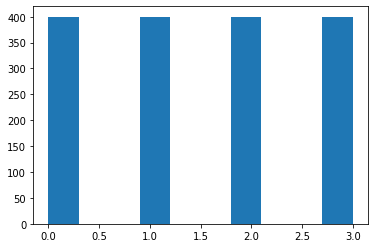

In [276]:
plt.hist(price_range)

列を掛け算して新しい列を作り、元のものを削除する関数を作成

In [277]:
def multiplication(g_col,col1,col2):
    train[g_col] = train[col1] * train[col2]
    test[g_col] = test[col1] * test[col2]
    train.drop([col1,col2], axis=1, inplace=True)
    test.drop([col1,col2],axis=1, inplace=True)
    

trainとtestから同じカラムを削除する関数を作成

In [278]:
def delete_column(col):
    train.drop(col,axis=1,inplace=True)
    test.drop(col,axis=1,inplace=True)

In [279]:
multiplication("sc_s", "sc_w", "sc_h")

In [280]:
delete_column("id")

In [281]:
multiplication("px", "px_width", "px_height")

In [282]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,three_g,touch_screen,wifi,price_range,sc_s,px
0,825,0,2.9,1,0,0,34,0.8,99,8,17,2915,10,1,1,0,3,16,2744886
1,1108,1,2.9,0,10,0,52,0.1,183,2,12,3264,13,0,1,1,3,16,221780
2,1703,1,1.5,1,17,1,55,0.7,138,5,19,2993,20,1,1,1,3,5,2414221
3,1334,1,2.4,0,5,1,42,0.6,115,5,14,2542,8,1,0,0,3,10,2343138
4,1187,1,2.2,0,0,1,46,0.4,145,2,9,3917,8,1,0,1,3,143,2127822


battery_powerの相関係数が高かったので詳しく見てみる

In [414]:
battery_power = train["battery_power"]

In [415]:
battery_power.describe()

count    1600.000000
mean     1239.182500
std       439.309407
min       501.000000
25%       856.000000
50%      1225.000000
75%      1617.000000
max      1998.000000
Name: battery_power, dtype: float64

(array([177., 158., 166., 167., 152., 148., 151., 157., 161., 163.]),
 array([ 501. ,  650.7,  800.4,  950.1, 1099.8, 1249.5, 1399.2, 1548.9,
        1698.6, 1848.3, 1998. ]),
 <BarContainer object of 10 artists>)

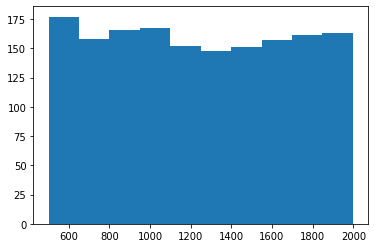

In [286]:
plt.hist(battery_power)

trainを目的変数のprice_rangeとそれ以外に分ける

In [287]:
trainx = train.drop("price_range", axis=1)
trainx_columns = trainx.columns

正規化してからモデルに学習させる

In [290]:
scaler = StandardScaler()

In [291]:
scaler.fit(trainx)

StandardScaler()

In [292]:
train_std = pd.DataFrame(scaler.transform(trainx), columns=trainx_columns)

In [293]:
train_std["price_range"] = price_range
train_std.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,three_g,touch_screen,wifi,sc_s,px,price_range
0,-0.943098,-1.001251,1.696949,0.996257,-1.005101,-1.038230,0.125433,1.037872,-1.145834,1.518986,1.180659,0.726774,-0.186069,0.560026,1.007528,-1.012579,-0.836417,2.209678,3
1,-0.298704,0.998751,1.696949,-1.003757,1.328274,-1.038230,1.120059,-1.372281,1.243171,-1.106084,0.350597,1.048822,0.359188,-1.785632,1.007528,0.987577,-0.836417,-0.823484,3
2,1.056118,0.998751,-0.014825,0.996257,2.961636,0.963177,1.285830,0.693565,-0.036653,0.206451,1.512683,0.798750,1.631454,0.560026,1.007528,0.987577,-0.981886,1.812168,3
3,0.215901,0.998751,1.085601,-1.003757,0.161586,0.963177,0.567489,0.349257,-0.690785,0.206451,0.682622,0.382579,-0.549574,0.560026,-0.992528,-1.012579,-0.915764,1.726715,3
4,-0.118820,0.998751,0.841062,-1.003757,-1.005101,0.963177,0.788517,-0.339358,0.162431,-1.106084,-0.147440,1.651392,-0.549574,0.560026,-0.992528,0.987577,0.843095,1.467872,3


In [294]:
train_std.corr().sort_values("price_range")

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,three_g,touch_screen,wifi,sc_s,px,price_range
touch_screen,-0.015330,0.006260,0.016465,-0.033723,-0.020754,0.005285,-0.043835,-0.007569,-0.002783,0.047946,-0.001281,-0.040349,0.015027,0.016325,1.000000,0.010095,0.008786,0.014151,-0.038014
mobile_wt,-0.010308,-0.012098,0.013321,0.007079,0.042621,-0.004577,-0.057488,0.025366,1.000000,-0.029389,0.027691,0.002630,-0.005786,0.012271,-0.002783,-0.016137,-0.014592,-0.017214,-0.029063
clock_speed,0.008738,0.000287,1.000000,-0.015339,-0.004345,-0.046593,0.013742,-0.000058,0.013321,-0.002155,0.001366,0.001007,-0.003745,-0.043143,0.016465,-0.028462,-0.003340,-0.001628,-0.004169
dual_sim,-0.036121,0.029996,-0.015339,1.000000,-0.043728,0.006114,-0.024395,-0.024298,0.007079,-0.035594,-0.013730,0.017834,-0.022281,-0.000832,-0.033723,0.028706,-0.013782,-0.002613,-0.003913
n_cores,-0.005447,0.035532,-0.002155,-0.035594,0.001605,-0.024815,-0.033980,0.000202,-0.029389,1.000000,0.010465,-0.005127,0.029916,-0.013634,0.047946,-0.015194,0.010306,-0.003408,-0.003057
m_dep,0.046582,0.005816,-0.000058,-0.024298,-0.010993,0.007723,-0.020205,1.000000,0.025366,0.000202,0.032275,-0.006299,0.030137,-0.006810,-0.007569,-0.024257,-0.018871,0.034496,0.007795
blue,0.000327,1.000000,0.000287,0.029996,0.003994,0.023720,0.031930,0.005816,-0.012098,0.035532,-0.023115,0.010712,0.034073,-0.025689,0.006260,-0.021267,-0.002980,-0.001333,0.011739
four_g,0.015852,0.023720,-0.046593,0.006114,-0.019038,1.000000,0.013693,0.007723,-0.004577,-0.024815,-0.029518,0.013276,-0.053362,0.581436,0.005285,-0.012979,0.042837,-0.001420,0.019020
wifi,-0.011539,-0.021267,-0.028462,0.028706,0.006979,-0.012979,0.024847,-0.024257,-0.016137,-0.015194,-0.000287,0.026283,-0.029364,0.012865,0.010095,1.000000,0.048761,0.066379,0.021244
talk_time,0.034079,0.034073,-0.003745,-0.022281,-0.000840,-0.053362,-0.009414,0.030137,-0.005786,0.029916,0.022182,0.006435,1.000000,-0.049808,0.015027,-0.029364,-0.024744,-0.010368,0.021540


blueが0か1の変数だったので、正規化してから特徴量作成

In [295]:
train_std["function"] = train_std["wifi"] * train_std["blue"]
train_std.drop(["wifi", "blue"], axis=1, inplace=True)

In [296]:
train_std.describe()

,battery_power,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,three_g,touch_screen,sc_s,px,price_range,function
count,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1.600000e+03,1600.000000,1600.000000
mean,2.464695e-16,3.053113e-16,8.548717e-17,-5.995204e-17,-1.065814e-16,-2.664535e-17,-7.105427e-17,1.909584e-16,-6.106227e-17,-8.215650e-17,-1.332268e-16,6.106227e-17,4.662937e-17,-3.941292e-17,-1.887379e-17,-4.218847e-17,1.500000,-0.021267
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.118384,1.000086
min,-1.680850e+00,-1.237521e+00,-1.003757e+00,-1.005101e+00,-1.038230e+00,-1.642790e+00,-1.372281e+00,-1.686204e+00,-1.543596e+00,-1.641550e+00,-1.726880e+00,-1.640087e+00,-1.785632e+00,-9.925279e-01,-1.048009e+00,-1.090097e+00,0.000000,-1.011314
25%,-8.725110e-01,-9.929819e-01,-1.003757e+00,-7.717637e-01,-1.038230e+00,-8.691923e-01,-1.027974e+00,-8.898688e-01,-6.685727e-01,-8.114889e-01,-8.377880e-01,-9.130781e-01,5.600258e-01,-9.925279e-01,-7.835187e-01,-7.757953e-01,0.750000,-1.011314
50%,-3.229372e-02,-1.482519e-02,9.962570e-01,-3.050888e-01,9.631775e-01,-4.033760e-02,4.949423e-03,-8.212205e-03,-2.310609e-01,1.857263e-02,2.858290e-03,-4.316617e-03,5.600258e-01,-9.925279e-01,-3.338856e-01,-3.533633e-01,1.500000,-0.988812
75%,8.602949e-01,8.410619e-01,9.962570e-01,6.282612e-01,9.631775e-01,8.437741e-01,1.037872e+00,8.450039e-01,1.081474e+00,8.486341e-01,8.783393e-01,9.044449e-01,5.600258e-01,1.007528e+00,5.389315e-01,5.479347e-01,2.250000,0.986343
max,1.727836e+00,1.819219e+00,9.962570e-01,3.428311e+00,9.631775e-01,1.783143e+00,1.726488e+00,1.726661e+00,1.518986e+00,1.678696e+00,1.726137e+00,1.631454e+00,5.600258e-01,1.007528e+00,3.474771e+00,3.581840e+00,3.000000,1.013846


ここからはデータを分ける→モデルを作る→チューニングの流れ

In [297]:
x = train_std.drop("price_range",axis=1)
y = price_range

In [298]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.4,random_state=1)


In [299]:
svm=SVC(random_state=1)
svm.fit(x_train,y_train)
print("train accuracy:",svm.score(x_train,y_train))
print("test accuracy:",svm.score(x_test,y_test))

train accuracy: 0.98125
test accuracy: 0.8421875


In [300]:
params = {"C":[1,0.1,0.25,0.5,2,0.75],
         "kernel":["linear","rbf"],
         "gamma":["auto",0.01,0.001,0.0001,1],
         "decision_function_shape":["ovo","ovr"],
         "tol":[0.1,0.01,0.001,0.0001]}

In [301]:
svm=SVC(random_state=1)
grid_svm=GridSearchCV(estimator=svm,cv=5,param_grid=params)
grid_svm.fit(x_train,y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)

best score:  0.91875
best param:  {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear', 'tol': 0.01}


In [302]:
svm_model=SVC(C=0.1,decision_function_shape="ovo",gamma="auto",kernel="linear",random_state=1,tol=0.01)

In [303]:
svm_model.fit(x_train,y_train)

SVC(C=0.1, decision_function_shape='ovo', gamma='auto', kernel='linear',
    random_state=1, tol=0.01)

In [304]:
print("train_accuracy:",svm_model.score(x_train,y_train))
print("test_accuracy: ", svm_model.score(x_test,y_test))

train_accuracy: 0.9385416666666667
test_accuracy:  0.8984375


テストデータに訓練データと同じ処理を加える

In [305]:
test.drop("price_range",axis=1,inplace=True)
test_columns = test.columns

In [306]:
test_std = pd.DataFrame(scaler.transform(test), columns=test_columns)

In [307]:
test_std["function"] = test_std["blue"] * test_std["wifi"]
test_std.drop(["blue","wifi"], axis=1, inplace=True)

In [376]:
pred = svm_model.predict(test_std)
train_pred = svm_model.predict(x)

In [309]:
scores = cross_val_score(estimator=svm_model, X=x, y=y, cv=8 )
scores.mean()

0.91875

混合行列を作成

In [317]:
confusion_matrix(test_price_range, pred)

array([[96,  4,  0,  0],
       [ 6, 89,  5,  0],
       [ 0,  3, 87, 10],
       [ 0,  0,  2, 98]])

lgbのモデルも作成　こちらは手作業で何度かチューニングした

In [362]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass', 
        'num_class': 4,
        'metric': {'multi_error'},
         "learning_rate":0.3,
         "num_leaves":26,
         
        
}


lgb_model = lgb.train(params,
train_set=lgb_train, 
valid_sets=lgb_eval, 
)

y_pred_prob = lgb_model.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1) 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 17
[LightGBM] [Info] Start training from score -1.373872
[LightGBM] [Info] Start training from score -1.357545
[LightGBM] [Info] Start training from score -1.415895
[LightGBM] [Info] Start training from score -1.398873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_error: 0.215625
[2]	valid_0's multi_error: 0.182812
[3]	valid_0's multi_error: 0.171875
[4]	valid_0's multi_error: 0.159375
[5]	valid_0's multi_error: 0.148438
[6]	valid_0's 

In [363]:
acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

Acc : 0.8828125


In [368]:
lgb_pred_prob = lgb_model.predict(test_std)

lgb_pred = np.argmax(lgb_pred_prob, axis=1) 

In [374]:
confusion_matrix(test_price_range, lgb_pred)

array([[97,  3,  0,  0],
       [ 8, 85,  7,  0],
       [ 0,  6, 87,  7],
       [ 0,  0,  7, 93]])

特徴量の重要度をDataFrameにして上から5つを表示

In [421]:
f_importance = np.array(lgb_model.feature_importance()) 
df_importance = pd.DataFrame({'feature':x_train.columns, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) 
df_importance.iloc[0:5]

,feature,importance
10,ram,1426
0,battery_power,1030
15,px,883
7,mobile_wt,390
14,sc_s,346


---

課題2: データセット「new-york-stock-exchange」は2010~2016年のアメリカの株価推移を記録したものである。

このデータを元に、**アップル（Apple Inc.）**の**「翌日の高値（high）」**と**「一週間後の安値（low）」**を予測するモデルを構築せよ。

例えば、1週間後の予測の場合、2016/1/1の株価を予測値は2015/12/24までのデータをインプットとすること。

なお、予測対象期間は2016/1/1 ~ 2016/12/30とする。

【データ】

- fundamentals.csv
    - Annual SEC 10K fillingから取得した変数。財務状況に関する情報を企業（Ticker symbol）ごとに集計
    
    
- securities.csv
    - 企業（Ticker symbol）ごとの業種業態をまとめたデータ。
    
    
- prices-split-adjusted.csv
    - 企業ごとに集計された日毎の株価データ
    - 予測対象である安値は「low」に格納されている

【提出要件】

以下の項目をJupyter Notebook上で出力した状態で提出すること

- 予測結果と実際のデータを比較できる株価のプロット図
    - 可視化する期間は予測対象である2016/1/1 ~ 2016/12/30のみで良い
    
    
- 予測精度を算出せよ（RMSE）


※余力があれば

自分が気になる企業に対して同様に予測モデルを構築してみよう。予測結果と比較できるように可視化できたら尚良い。

In [278]:
# 以下よりコードを記入してください  ##############################
fundamentals = pd.read_csv('../stock/fundamentals.csv')
price_split = pd.read_csv('../stock/prices-split-adjusted.csv')
prices = pd.read_csv('../stock/prices.csv')
securities = pd.read_csv('../stock/securities.csv')

In [279]:
fundamentals.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [280]:
price_split.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [282]:
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [283]:
securities.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


---

課題3: データセット「new-york-city-taxi-fare-prediction」はニューヨーク州のタクシー乗車履歴を記録したものである。

このデータを元に、**タクシーの運賃価格（fare_amount）**を予測するモデルを構築せよ。

【データ】

- train.csv
    - 学習用のデータ
    - 予測対象のカラムである「fare_amount」と客が乗車した時間、緯度経度などの情報が記録されている。
    
    
- test.csv
    - 精度検証用のデータ
    - train.csvと同じカラム構成。test.csvに格納されている「fare_amount」を正とした予測結果を算出すること。
    
    
【提出要件】

以下の項目をJupyter Notebook上で出力した状態で提出すること

- データ前処理の過程（どういう処理をしたのかをコメント交えながら記載すること）
    
- 予測精度を算出せよ（RMSE）

In [272]:
# 以下よりコードを記入してください  ##############################
train = pd.read_csv('../taxi/train.csv')
test = pd.read_csv('../taxi/test.csv')
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [274]:
train.shape

(1519661, 8)